In [1]:
import glob
import math
import time
import operator
import cv2
from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from tempfile import TemporaryFile
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label

In [22]:
def normalize_gray_to_rgb(img):
    img *= 255.0 / img.max()
    img = np.expand_dims(img, 2)
    img = np.array(cv2.merge((img, img, img)), np.uint8)
    
    return img

def load_images(files, num=0):
    imgs = None
    files_sel = []
    
    if num == 0: 
        num = len(files)
        files_sel = files
    else:
        for i in range(num):
            idx = np.random.choice(len(files), 1)[0]
            files_sel.append(files[idx])
            
    for fname in files_sel:
        img = cv2.imread(fname)
        
        if imgs is None:
            imgs = np.empty([0, img.shape[0], img.shape[1], img.shape[2]], dtype = np.uint8)
            
        imgs = np.append(imgs, img[None,:], axis=0)
        
    return imgs

def display_image_set(imgs, filename, cols_num=6):
    height_init, width_init, _ = imgs[0].shape
    
    if width_init > 300:
        width_img = int(math.ceil(float(300) / float(cols_num)))
    else:
        width_img = width_init
        
    imgs_num = len(imgs)
    rows_num = int(math.ceil(float(imgs_num) / float(cols_num)))
    Kwidth = float(width_init) / float(width_img)
    height_img = int(height_init / Kwidth)
    result_shape = (rows_num * height_img, cols_num * width_img, 3)
    results_image = 255 * np.ones(shape=result_shape, dtype=np.uint8)

    for idx, img in enumerate(imgs):
        if img.shape[2] == 1:
            img = np.array(cv2.merge((img,img,img)),np.uint8)
            
        row = idx // cols_num
        col = idx - row * cols_num
        
        if width_init != width_img:
            img_resized = cv2.resize(img, (width_img, height_img), interpolation = cv2.INTER_AREA)
        else:
            img_resized = img
        
        h, w, _ = img_resized.shape
        origin_y = row * h
        origin_x = col * w
        results_image[origin_y:origin_y+h, origin_x:origin_x+w, :] = img_resized

    plt.rcParams["figure.figsize"] = (25, 25)
    cv2.imwrite('./preview/{}.jpg'.format(filename), cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
    plt.imshow(results_image.astype(np.uint8))
    plt.axis('off') 
    plt.show()

In [23]:
def to_colorspace(img, space='LUV'):
    if space == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif space == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif space == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif space == 'gray':
        return np.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 2)
    else: 
        return img

def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel() 
                        
def color_hist(img, nbins=32):
    channels = []
    
    for idx in range(img.shape[-1]):
        ch = np.histogram(img[:,:,idx], bins=nbins, range=(0, 255))
        channels.append(ch[0])

    return np.hstack(tuple(channels))

def extract_hog(img, orient, ppc, cpb, vis=False, vec=False):
    return hog(
        img, 
        orientations=orient, 
        pixels_per_cell=(ppc, ppc), 
        cells_per_block=(cpb, cpb), 
        transform_sqrt=True, 
        visualise=vis, 
        feature_vector=vec
    )

def hog_features(img, space='LUV', orient=8, ppc=8, cpb=2, vis=False, vec=False):
    features = []
    previews = []
    img = to_colorspace(img, space)
    
    for idx in range(img.shape[-1]):
        hog = extract_hog(img[:,:,idx], orient, ppc, cpb, vis=vis, vec=vec)

        if vis:
            _, preview = hog
            preview = normalize_gray_to_rgb(preview)
            previews.append(preview)
        else:
            feature = hog
            features.append(feature)
    
    if vis:
        return np.array(previews).astype(np.uint8)
    else:
        return np.array(features).astype(np.float64)

def hogs_from_files(files):
    features = []

    for file in files:
        img = load_images([file])[0]
        feature_hogs = hog_features(img, vec=True)
        features.extend(feature_hogs)
    
    return features

def hog_preview(files):
    previews = []

    for file in files:
        img = load_images([file])[0]
        previews.append(img)
        preview_hogs = hog_features(img, vis=True)
        previews.extend(preview_hogs)
    
    return previews

def draw_boxes(img, bboxes):
    img = np.copy(img)
    
    for bbox in bboxes:
        color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        cv2.rectangle(img, bbox[0], bbox[1], color, 2)

    return img

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap


def draw_labeled_bboxes(img, labels):
    rects = []
    
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

    return img, rects

In [4]:
files_cars = glob.glob('./source_images/vehicles/**/*.png')
files_noncars = glob.glob('./source_images/non-vehicles/**/*.png')
print("Cars in dataset: {}; Non-cars in dataset: {}".format(len(files_cars), len(files_noncars)))

Cars in dataset: 8792; Non-cars in dataset: 8968


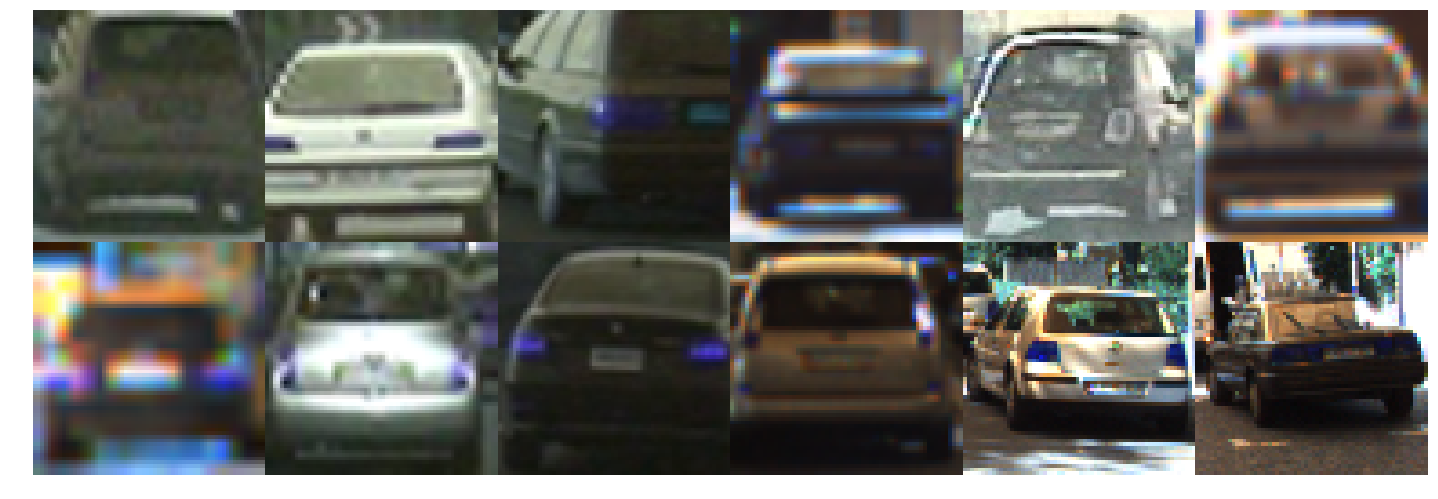

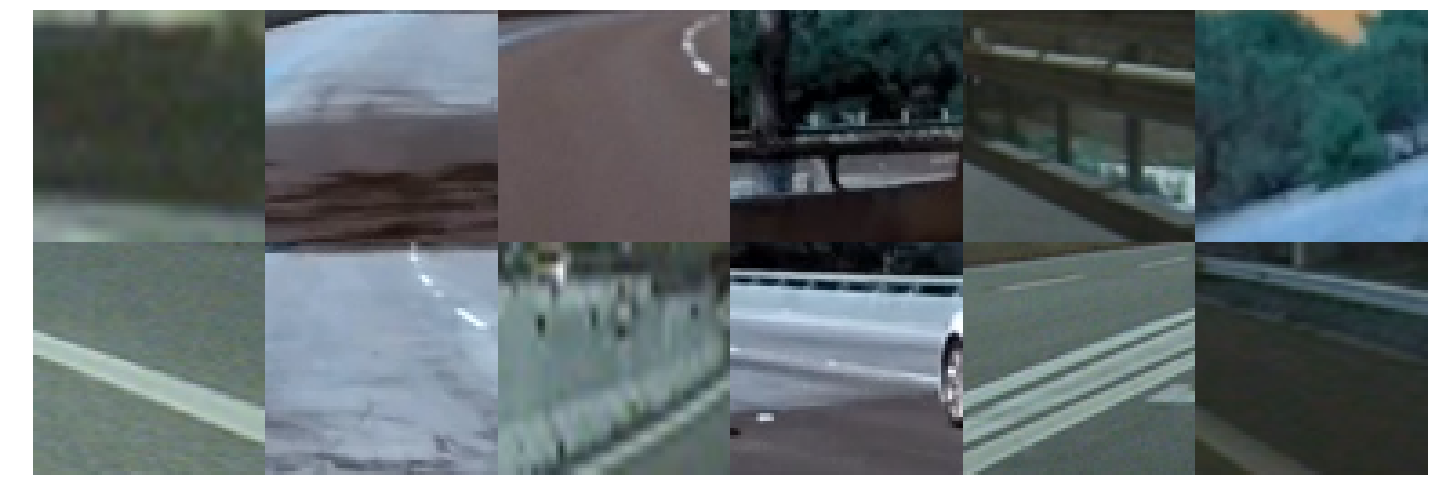

In [17]:
preview_cars = load_images(files_cars, num=12)
display_image_set(preview_cars, "cars")

preview_noncars = load_images(files_noncars, num=12)
display_image_set(preview_noncars, "noncars")

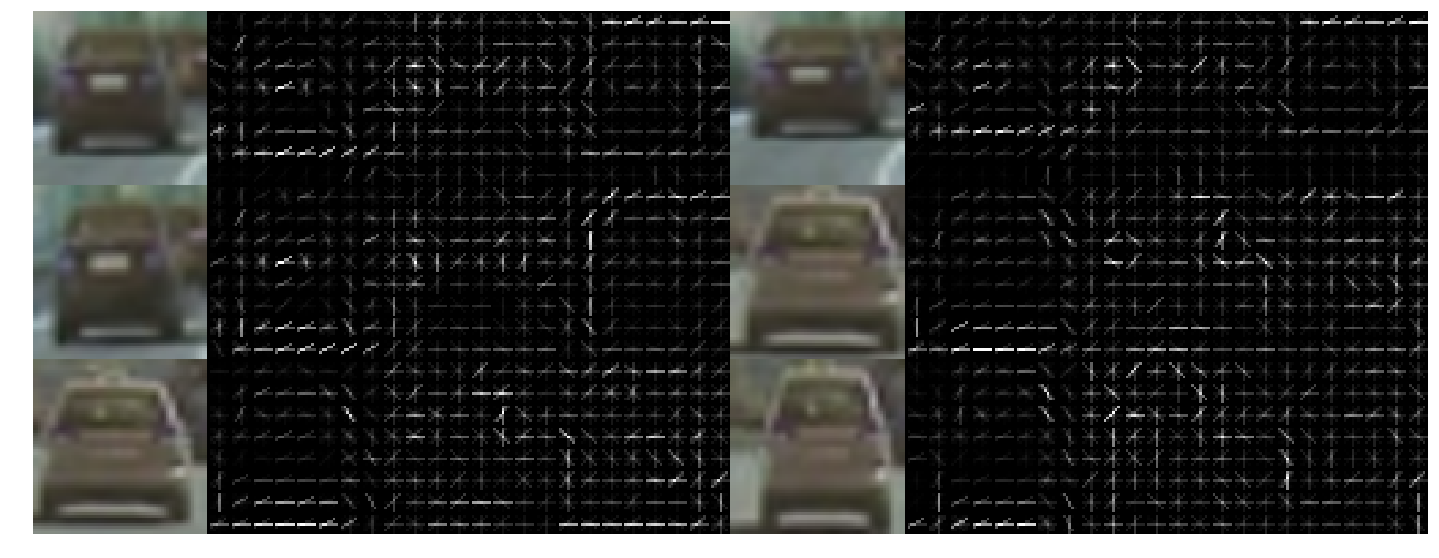

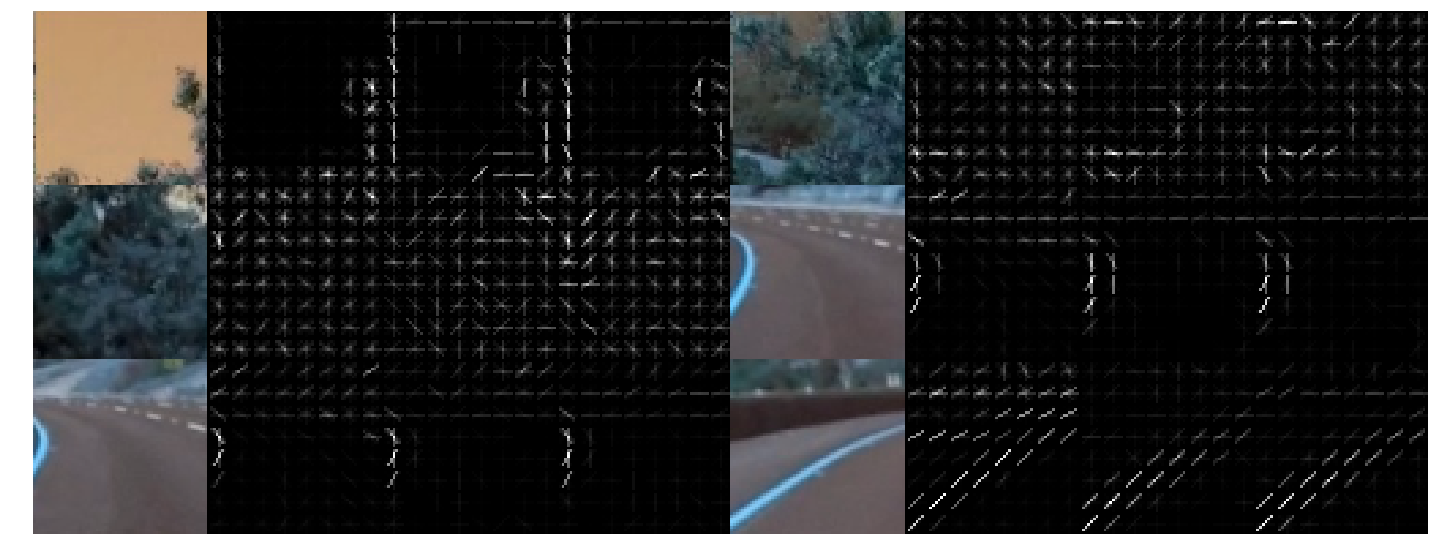

In [37]:
preview_cars = hog_images(files_cars[:6])
display_image_set(preview_cars, "hog_cars", cols_num=8)

preview_noncars = hog_images(files_noncars[:6])
display_image_set(preview_noncars, "hog_noncars", cols_num=8)

In [8]:
imgs = load_images(files_cars, num=100)

colorspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orientations = range(6, 13)
px_per_cells = range(6, 17)
cells_per_blocks = range(1, 4)
channels = [None, 0, 1, 2]

for space in colorspaces:
    for orientation in orientations:
        for px_per_cell in px_per_cells:
            for cells_per_block in cells_per_blocks:
                for channel in channels:
                    t = time.time()
                    hog_images(imgs, channel=channel, orient=orientation, pix_per_cell=px_per_cell, 
                                                   cell_per_block=cells_per_block, colorspace=space)
                    t2 = time.time()
                    print('Images: {} | Time: {}sec | Space {} | Orient {} | PPC {} | CPB {} | Channel {}'
                          .format(len(imgs), round(t2 - t, 2), space, orientation, px_per_cell, cells_per_block, channel))

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Images: 100 | Time: 19.65sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel None
Images: 100 | Time: 6.96sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 0
Images: 100 | Time: 6.76sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 1
Images: 100 | Time: 6.65sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 2
Images: 100 | Time: 20.54sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel None
Images: 100 | Time: 6.4sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 0
Images: 100 | Time: 6.65sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 1
Images: 100 | Time: 6.35sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 2
Images: 100 | Time: 24.58sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel None
Images: 100 | Time: 8.66sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 0
Images: 100 | Time: 8.64sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 1
Images: 100 | Time: 11.19sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 2
Images: 100 | Time: 21.11sec | Space RGB

Images: 100 | Time: 2.06sec | Space RGB | Orient 6 | PPC 14 | CPB 2 | Channel 1
Images: 100 | Time: 1.84sec | Space RGB | Orient 6 | PPC 14 | CPB 2 | Channel 2
Images: 100 | Time: 5.61sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel None
Images: 100 | Time: 1.82sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 0
Images: 100 | Time: 1.85sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 1
Images: 100 | Time: 2.38sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 2
Images: 100 | Time: 6.22sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel None
Images: 100 | Time: 2.03sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 0
Images: 100 | Time: 2.39sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 1
Images: 100 | Time: 1.92sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 2
Images: 100 | Time: 6.42sec | Space RGB | Orient 6 | PPC 15 | CPB 2 | Channel None
Images: 100 | Time: 2.43sec | Space RGB | Orient 6 | PPC 15 | CPB 2 | Channel 0
Images: 100 | Time: 2.14sec | S

Images: 100 | Time: 5.74sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel None
Images: 100 | Time: 1.54sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 0
Images: 100 | Time: 1.44sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 1
Images: 100 | Time: 1.54sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 2
Images: 100 | Time: 4.34sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel None
Images: 100 | Time: 1.43sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 0
Images: 100 | Time: 1.51sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 1
Images: 100 | Time: 2.1sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 2
Images: 100 | Time: 4.1sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel None
Images: 100 | Time: 1.08sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 0
Images: 100 | Time: 0.89sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 1
Images: 100 | Time: 1.41sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 2
Images: 100 | Time: 2.79sec | Spa

KeyboardInterrupt: 

In [5]:
features_cars = hogs_from_files(files_cars)
print("Processed cars", len(features_cars))
features_noncars = hogs_from_files(files_noncars)
print("Processed noncars", len(features_noncars))

X = np.vstack((features_cars, features_noncars)).astype(np.float64)
y = np.append(np.ones(len(features_cars)), np.zeros(len(features_noncars)))
print("Stacked", X.shape, y.shape)

X_scaler = StandardScaler().fit(X)
print("Scaler fitted")
scaled_X = X_scaler.transform(X)
print("Scaled")

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
print("Train features {}, labels {}".format(X_train.shape, y_train.shape))
print("Test features {}, labels {}".format(X_test.shape, y_test.shape))

Processed cars 26376
Processed noncars 26904
Stacked (53280, 1568) (53280,)
Scaler fitted
Scaled
Train features (42624, 1568), labels (42624,)
Test features (10656, 1568), labels (10656,)


In [6]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy', round(svc.score(X_test, y_test), 4))

X = X_test[0:10]
y = y_test[0:10]
print('Prediction:', svc.predict(X))
print('True Label:', y)

Test Accuracy 0.903
Prediction: [ 1.  0.  1.  1.  1.  0.  1.  0.  0.  1.]
True Label: [ 1.  0.  1.  1.  1.  0.  1.  0.  0.  1.]


In [30]:
class Vehicle():
    def __init__(self):
        self.prev_rects = []
        self.max_rects = 15
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        slice_num = len(self.prev_rects) - self.max_rects
        self.prev_rects = self.prev_rects[slice_num:]
        
    def search(self, img, show_data=False):
        test_results = []
        rectangles = []
        window = 64
        top_margin = 400
        scales = [1.0, 1.5, 2.0, 3.5]

        for scale in scales:
            win_offset = top_margin + window / 2.0

            bbox = (int(top_margin), int(top_margin + window * scale), scale)
            rects = find_cars(img, bbox, svc, X_scaler, window, show_slices=False)
            rectangles.append(rects)

            bbox = (int(win_offset), int(win_offset + window * scale), scale)
            rects = find_cars(img, bbox, svc, X_scaler, window, show_slices=False)
            rectangles.append(rects)

        rectangles = [item for sublist in rectangles for item in sublist] 

        test_img_rects = draw_boxes(img, rectangles)
        heatmap_img = np.zeros_like(img[:,:,0])
        heatmap_img = add_heat(heatmap_img, rectangles)
        tresh_img = apply_threshold(heatmap_img, 1)
        labels = label(tresh_img)
        draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)

        if show_data:
            f, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(3, 2, figsize=(25,25))
            ax1.imshow(test_img_rects, cmap='hot')
            ax1.axis('off')
            ax2.imshow(heatmap_img, cmap='hot')
            ax2.axis('off')
            ax3.imshow(tresh_img, cmap='hot')
            ax3.axis('off')
            ax4.imshow(labels[0], cmap='gray')
            ax4.axis('off')
            ax5.imshow(draw_img)
            ax5.axis('off')
            plt.show()
            plt.close(f)

        return draw_img, rects
        
    def process_frame(self, img):
        draw_img, rects = self.search(img)
        self.add_rects(rects)
        
        return draw_img
    
def find_cars(img_init, bbox, svc, scaler, window, cps=2, show_all=False, show_slices=False):
    rectangles = []
    ystart, ystop, scale = bbox
    
    img = np.copy(img_init)
    img_slice = img[ystart:ystop, :,:]
    img = img_slice.astype(np.float32) / 255.0
    
    if show_slices:
        plt.figure(figsize=(15,15))
        plt.imshow(img_slice)
        plt.show()

    if scale != 1:
        imshape = img.shape
        img = cv2.resize(img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    orient=8
    ppc=8
    cpb=2
    
    nblocks_per_window = (window // ppc) - 1 
    nxblocks = (img.shape[1] // ppc) + 1
    nyblocks = (img.shape[0] // ppc) + 1
    nxsteps = (nxblocks - nblocks_per_window) // cps
    nysteps = (nyblocks - nblocks_per_window) // cps
    feature = hog_features(img)[0]

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cps
            xpos = xb * cps
            xleft = xpos * ppc
            ytop = ypos * ppc
            
#             subimg = img[ytop:ytop+window, xleft:xleft+window]
#             subimg = cv2.resize(subimg, (64,64))
            
#             spatial_feature = bin_spatial(subimg, size=(16, 16))
#             hist_feature = color_hist(subimg, nbins=32)
            hog_feature = feature[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

#             print(spatial_feature.shape)
#             print(hist_feature.shape)
#             print(hog_feature.shape)
            win_features = np.hstack((hog_feature)).reshape(1, -1)
#             print(win_features.shape)
            win_features = scaler.transform(win_features)
            prediction = svc.predict(win_features)
            
            if prediction == 1 or show_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

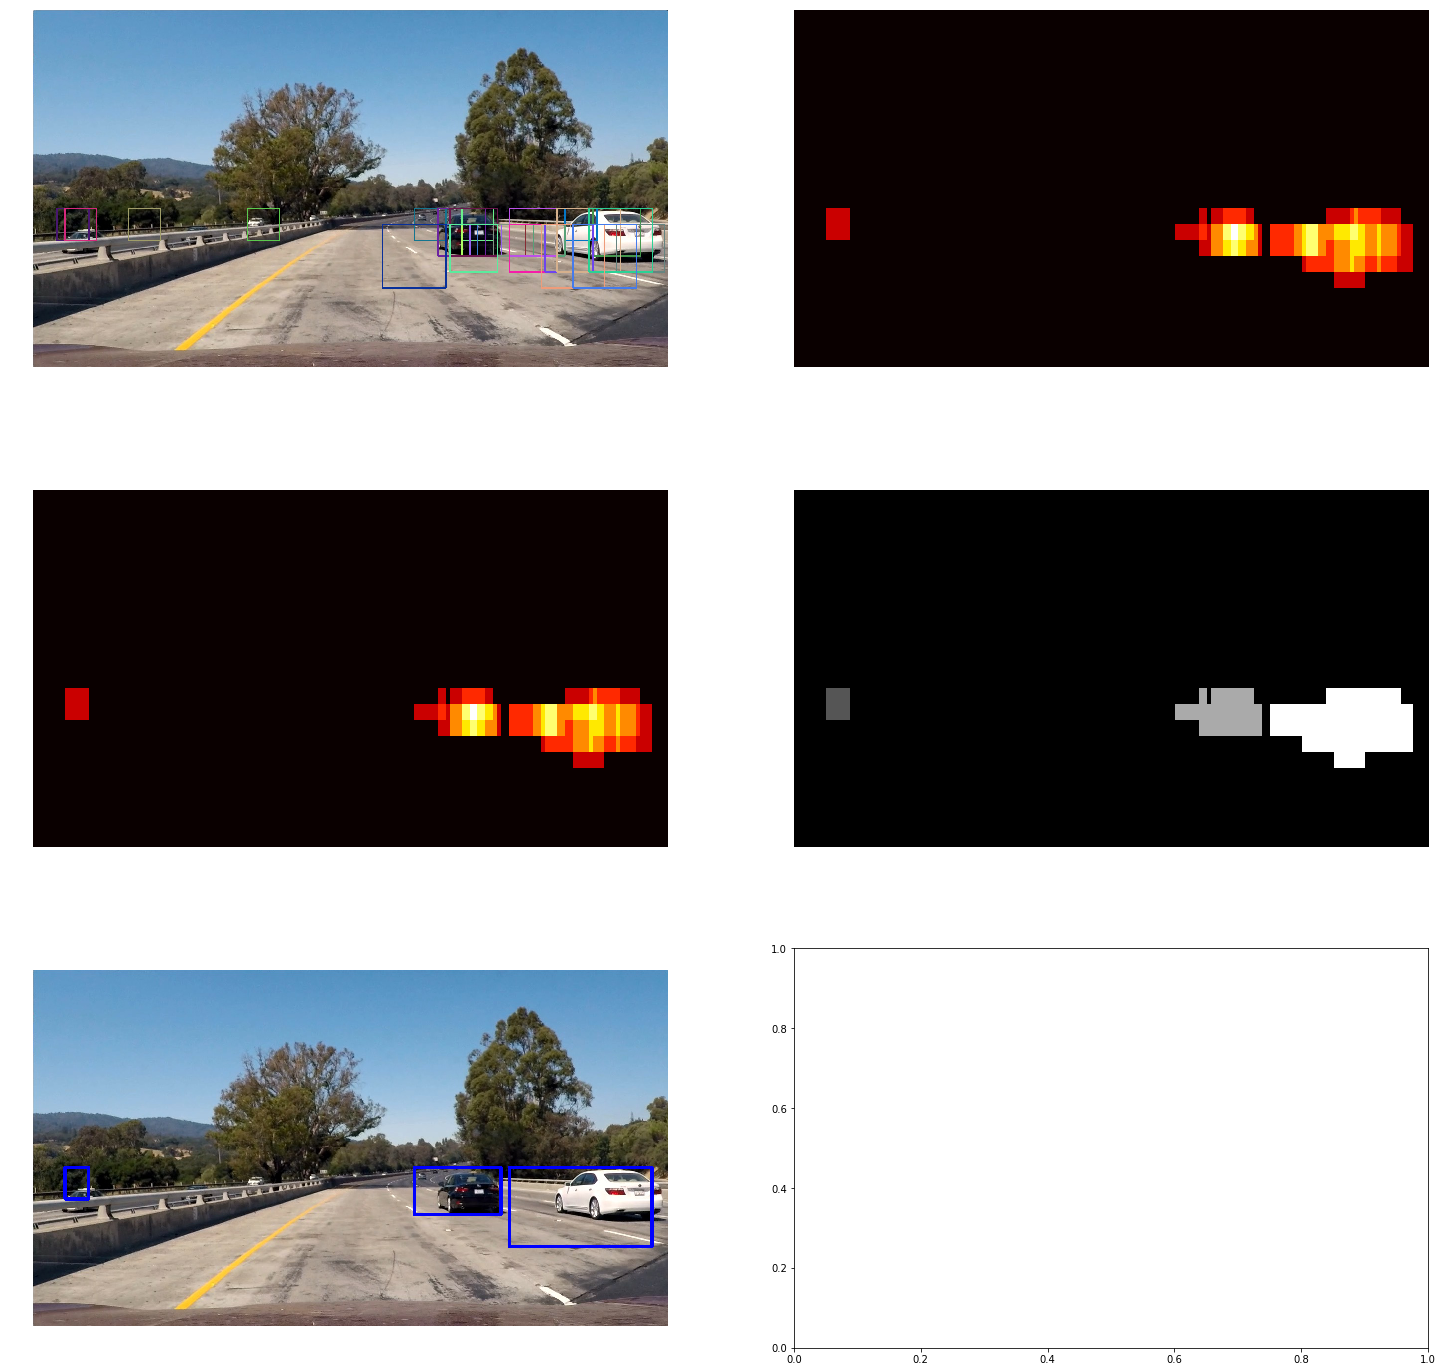

In [31]:
test_files = glob.glob('./test_images/test*.jpg')
results = []
vehicle = Vehicle()

for idx, file in enumerate(test_files):
    img = mpimg.imread(file)
    vehicle.search(img, show_data=True)
    break

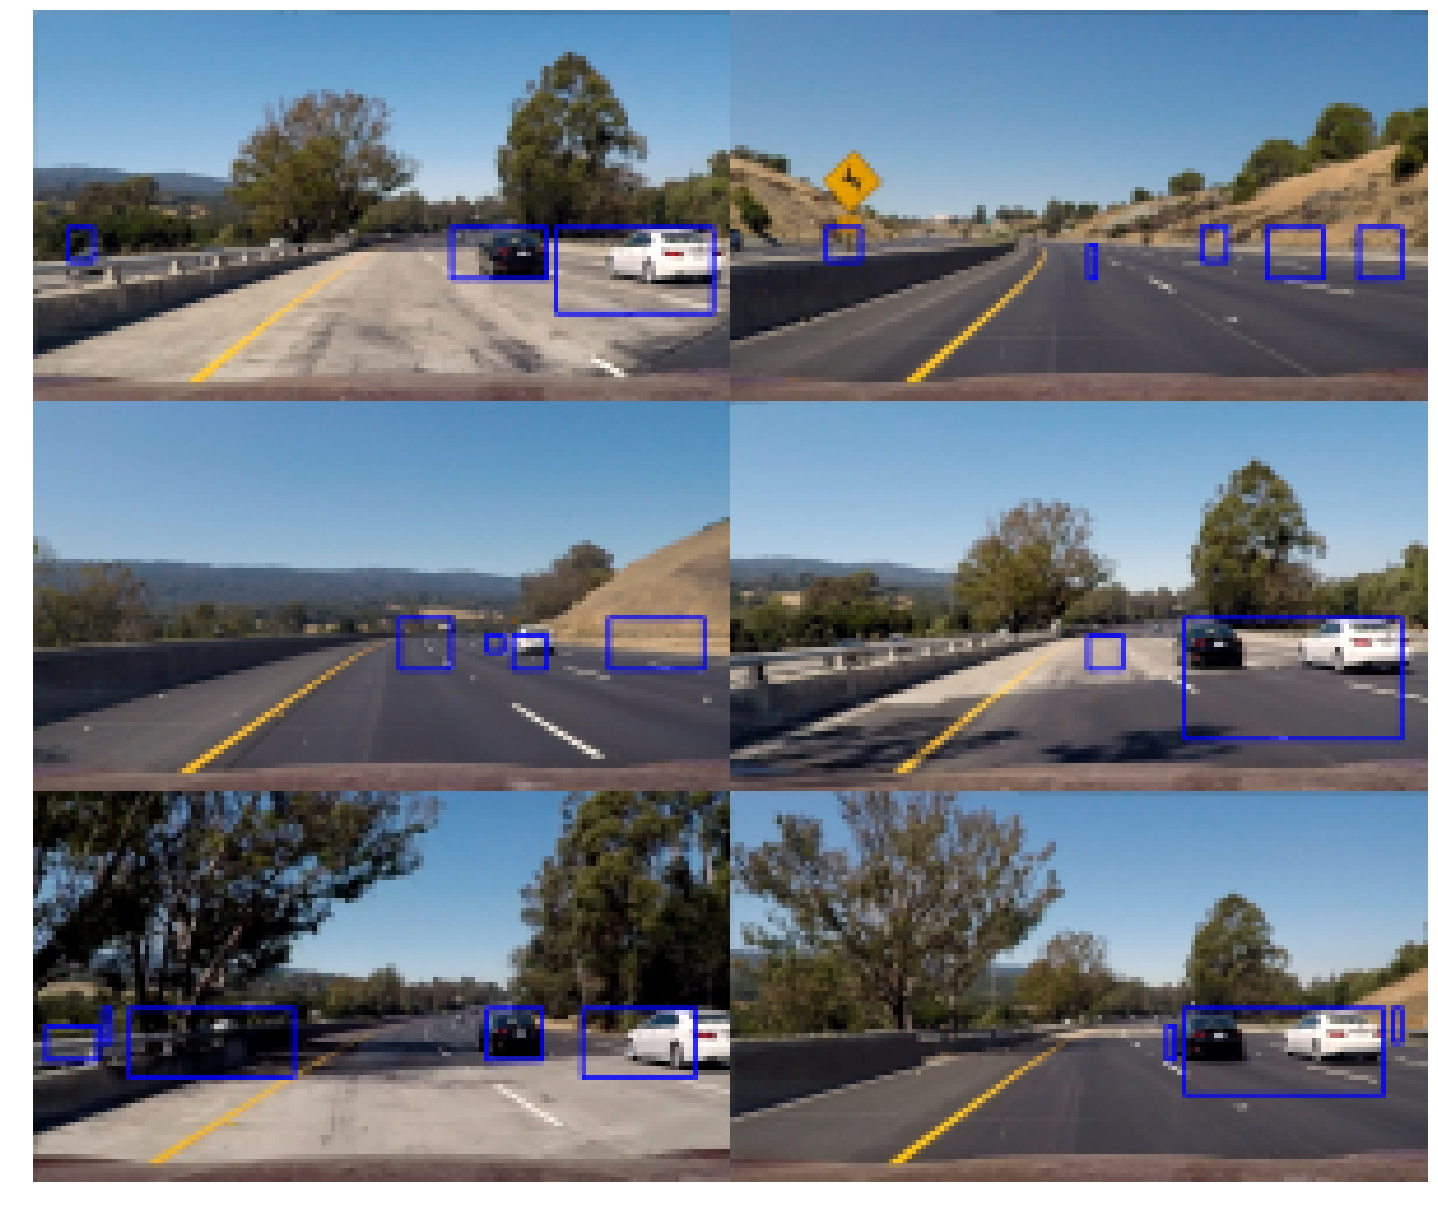

In [32]:
test_files = glob.glob('./test_images/test*.jpg')
results = []
vehicle = Vehicle()

for idx, file in enumerate(test_files):
    img = mpimg.imread(file)
    draw_img, _ = vehicle.search(img)
    results.append(draw_img)
    
display_image_set(results, "result_preview", cols_num=2)

In [ ]:
vehicle = Vehicle()
source = './output_videos/test_video.mp4'
out = './source_videos/test_video.mp4'
clip = VideoFileClip(out)
clip_out = clip.fl_image(vehicle.process_frame)
%time clip_out.write_videofile(source, audio=False)

[MoviePy] >>>> Building video ./source_videos/test_video.mp4
[MoviePy] Writing video ./source_videos/test_video.mp4


 23%|██▎       | 9/39 [00:45<02:33,  5.11s/it]

In [35]:
vehicle = Vehicle()
source = './output_videos/project_video.mp4'
out = './source_videos/project_video.mp4'
clip_proj = VideoFileClip()
clip_proj_out = clip_test2.fl_image(vehicle.process_frame)
%time clip_proj_out.write_videofile(source, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_out.mp4
[MoviePy] Writing video ./output_videos/project_video_out.mp4


 97%|█████████▋| 38/39 [03:07<00:05,  5.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_out.mp4 

CPU times: user 3min 4s, sys: 2.29 s, total: 3min 6s
Wall time: 3min 10s
